##### 여러분이 시도해볼 수 있는 방법은 다음과 같은 것들이 있습니다.

기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)  
LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기  
다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기  
Baseline 커널에서 활용했던 블렌딩 방법 활용하기



##### 프로젝트 루브릭
데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?  
제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?  
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?  


# 0. 라이브러리들 준비

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('라이브러이 준비완료')

라이브러이 준비완료


# 1. Preparing of Data

In [103]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


##### Description of parameters

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

## 1) Counting of the Data

In [111]:
train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


### The results of the Counting
#### # of training data = 15,035 ea
#### # of testing data = 6,468 ea

In [112]:
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [113]:
sub

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


## 2) Removing the price column because it is target values(labels)

In [114]:
y=data['price']
# del data['price']

In [115]:
print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### ---> Confirmed the removing (Canceld!!!!)

## 3) Combining training and testing data

In [119]:
train_len= len(train)
print(train_len)

15035


In [120]:
data=pd.concat((train,sub), axis=0)

In [121]:
print(len(data))

21503


In [122]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [123]:
data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,NaN,3,1.75,1500,11968,1.0,0,0,...,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,NaN,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,NaN,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,NaN,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,NaN,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


#### ---> Confirmed the combining

## 4) Preprocessing the data
### ① finding missing values!

<AxesSubplot:>

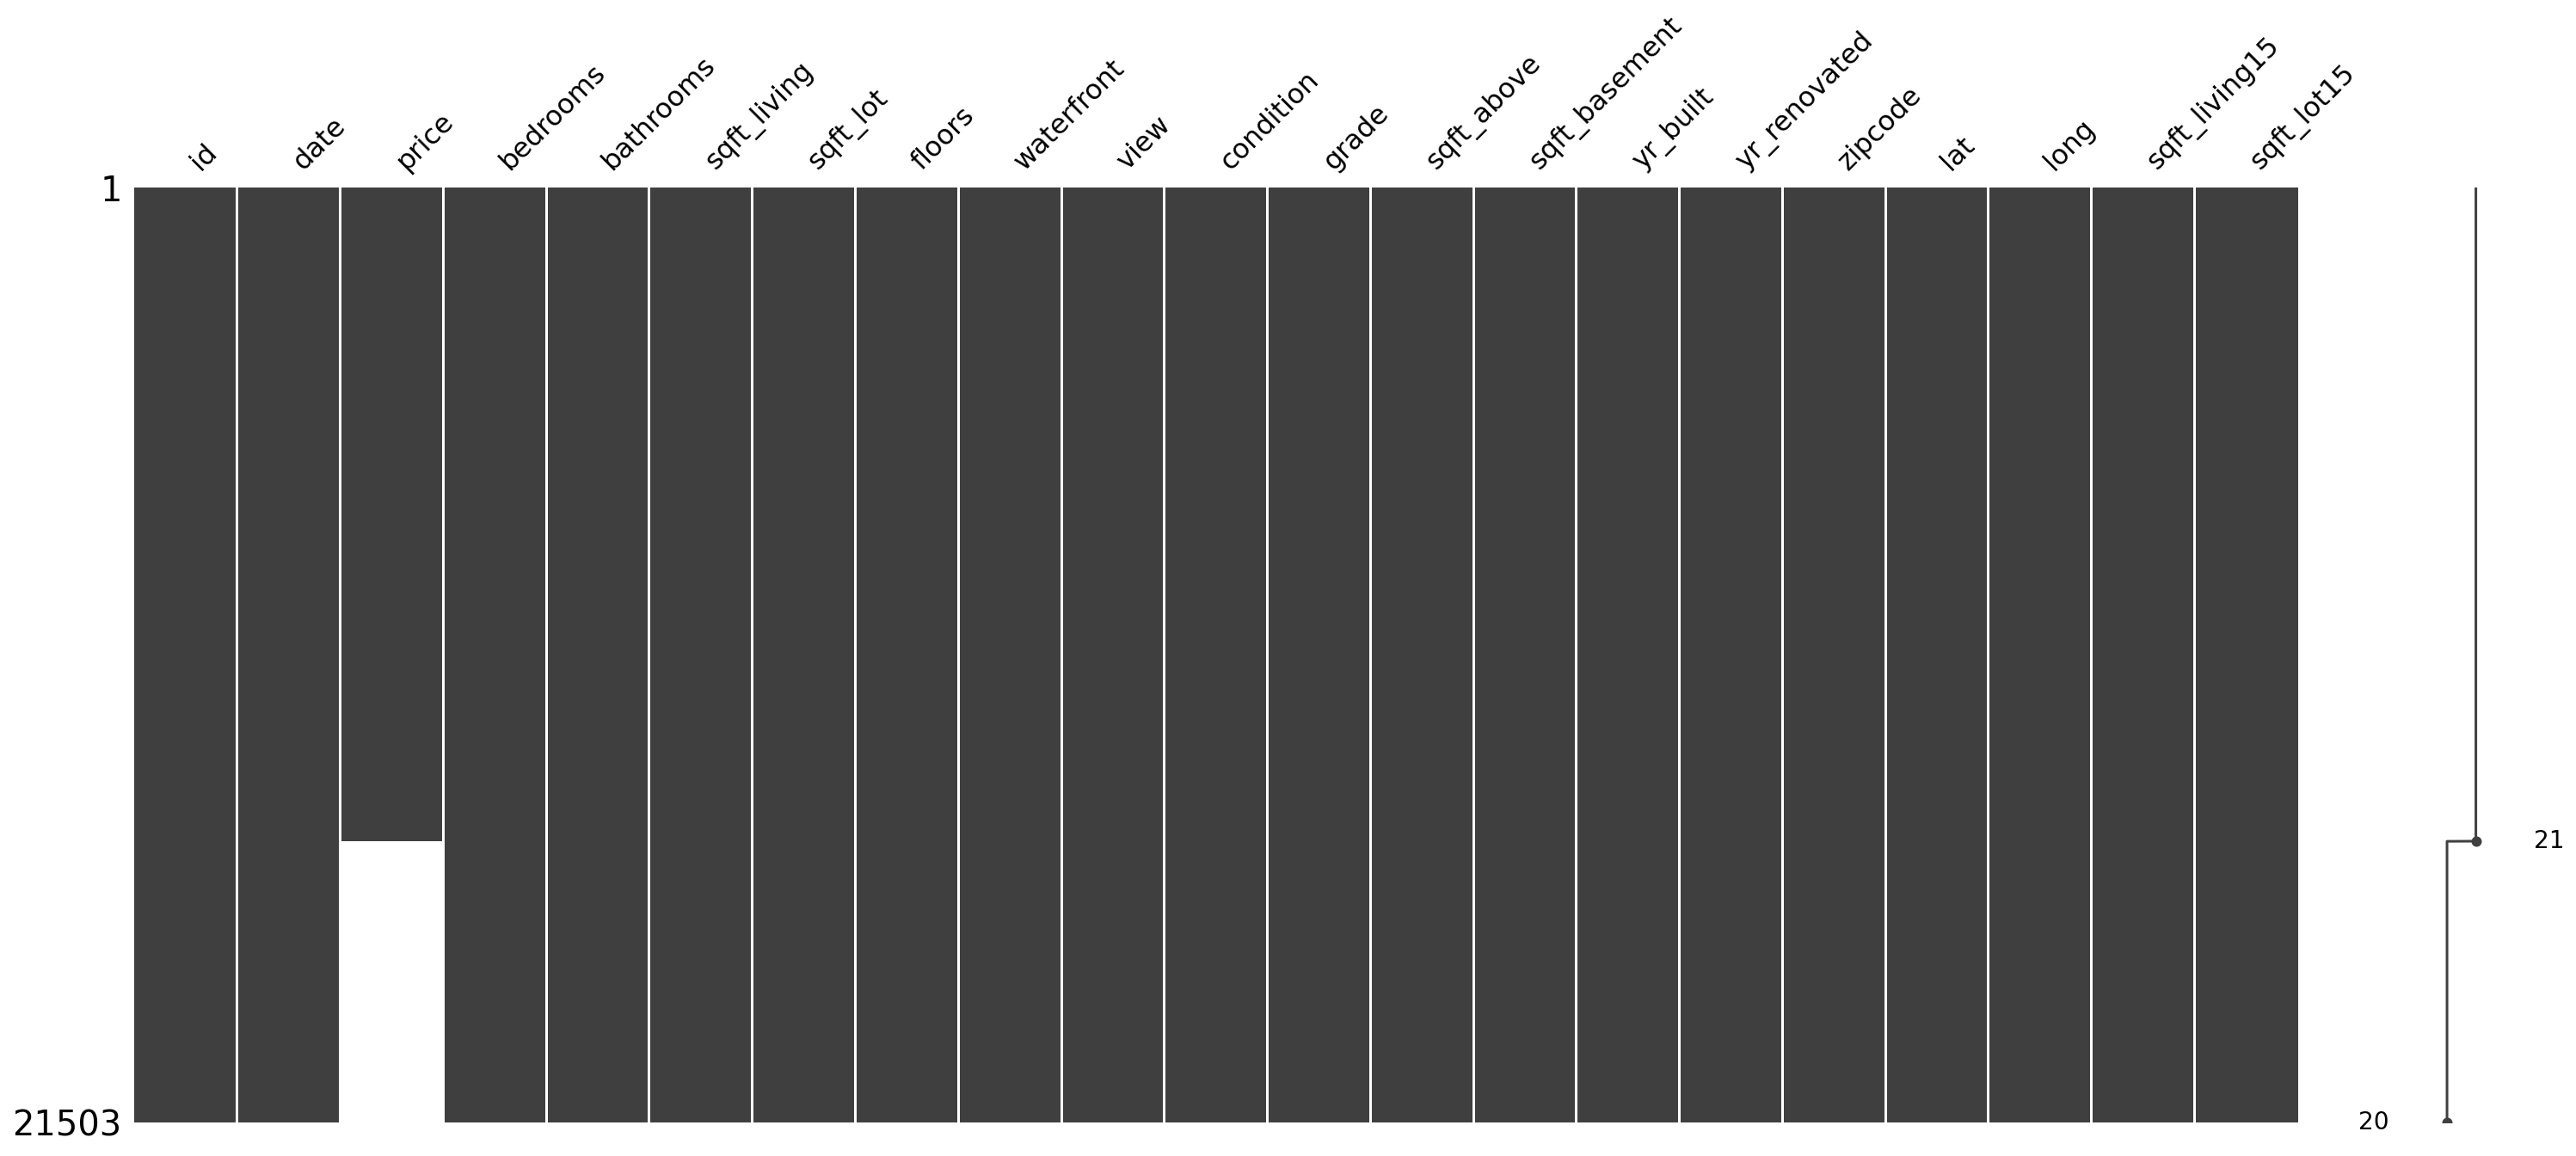

In [124]:
msno.matrix(data)

#### ---> Confirmed not existing missing values
#####         If there has a missing value, we can find a region with white color.

test용이므로 sub에는 price가 없다!!! 

### ② Removing unnecessary columns or modifing them

#### "id" column

In [125]:
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [126]:
null_data=data.loc[null_check,'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [127]:
print('{}: {}'.format('id', len(null_data.values)))

id: 0


##### --> Confirmed that there are no missing data.

#### Searching missing values in "ALL columns"

In [128]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


#### Removing "id" column

In [129]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### Correcting "data" column

In [130]:
data['date']=data['date'].apply(lambda x : str(x[:6]))

In [131]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 5) Distribution of each parameter

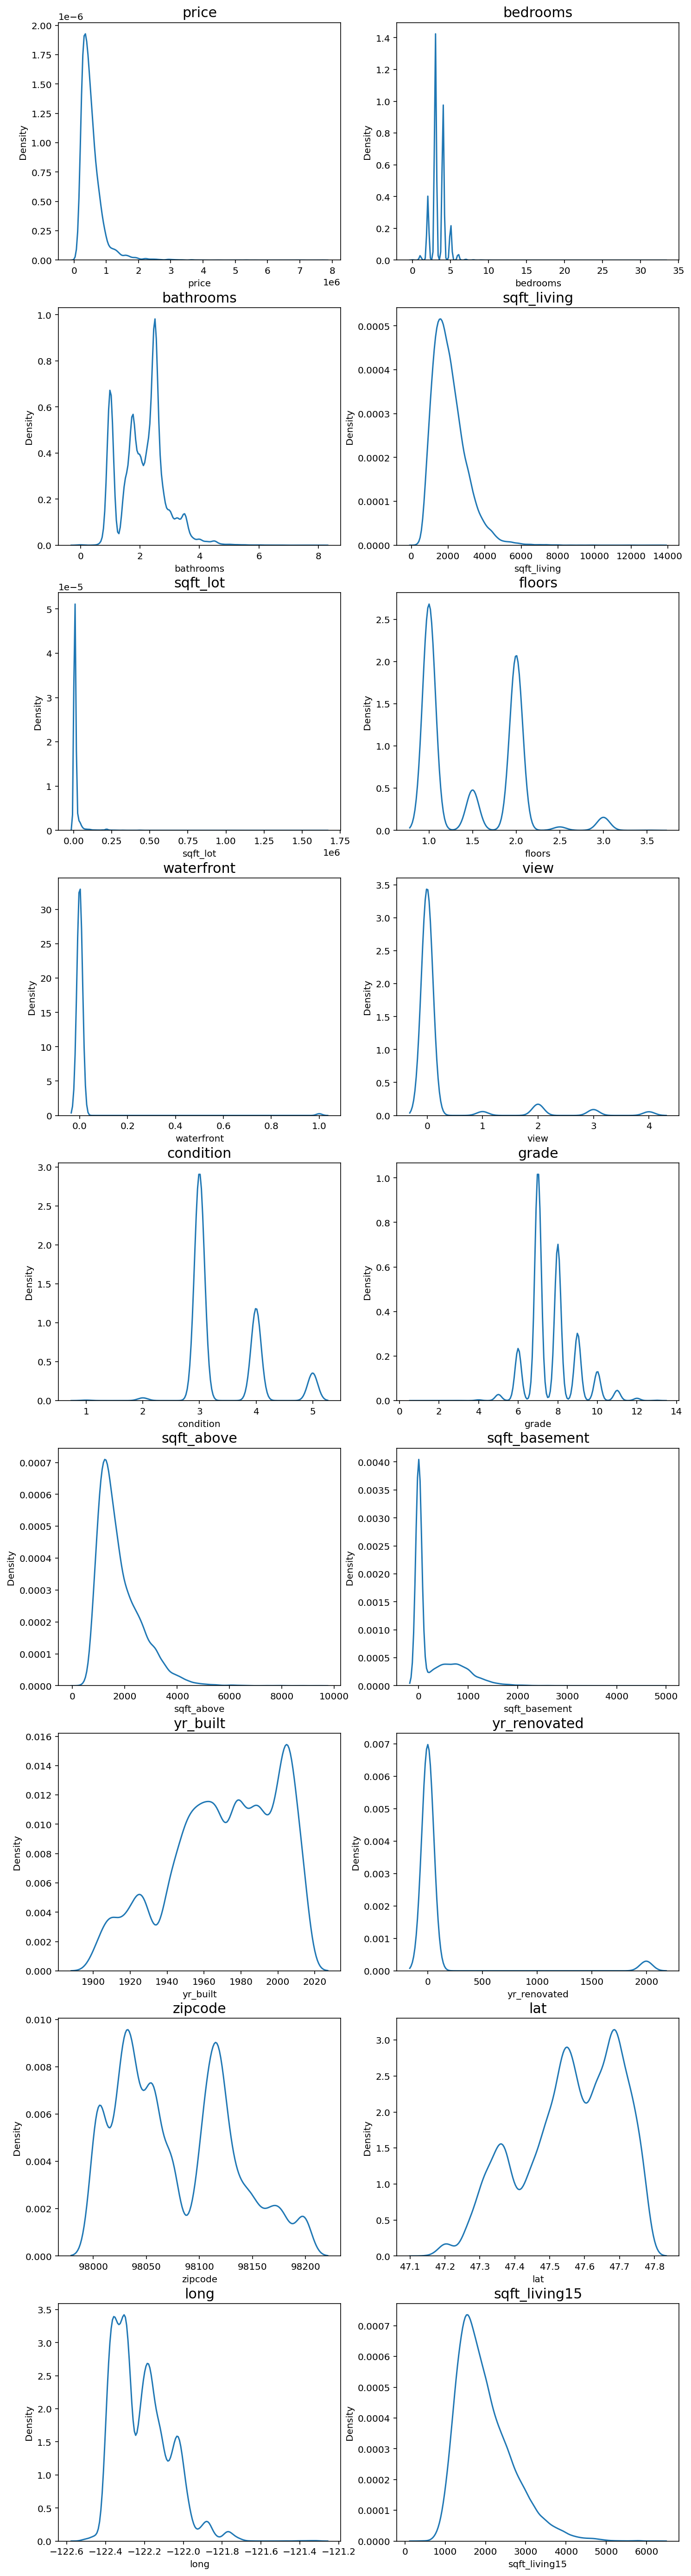

In [132]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id 변수(count==0인 경우)는 제외
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

##### In the former graphs. we can find the serious skewness of bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15 and sqft_lot15. Thus, with log-scaling, we can make closly normal distribution of the seven graphs.

In [133]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

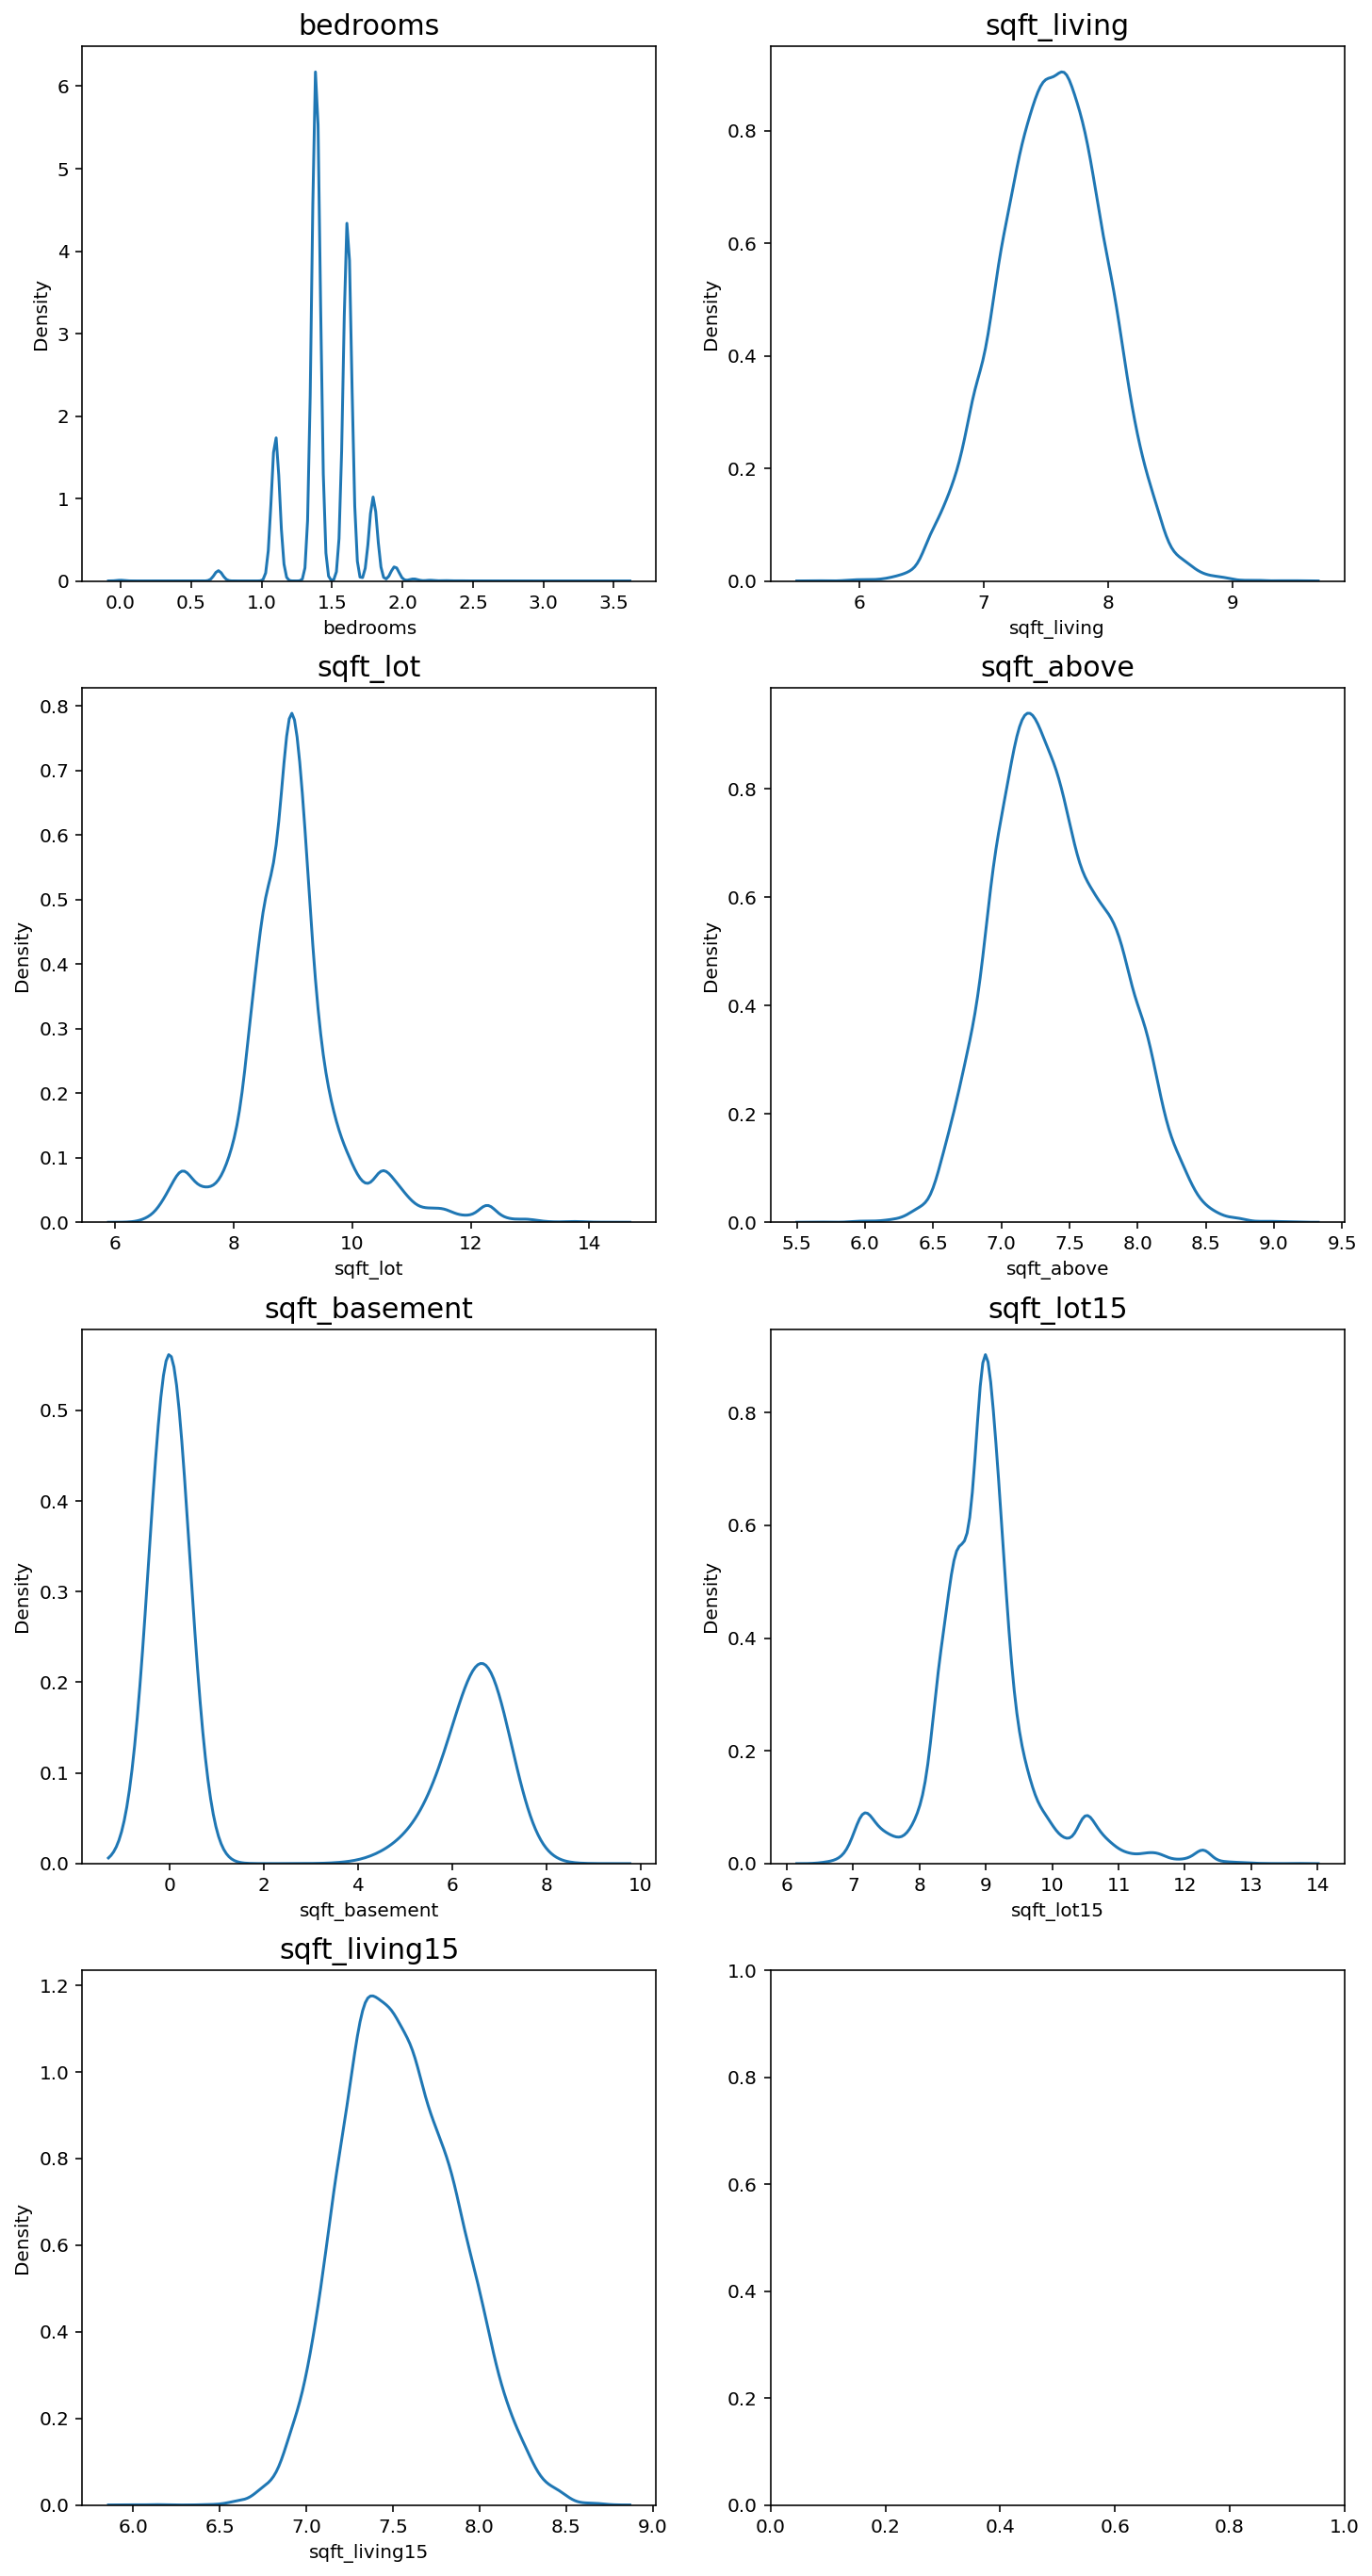

In [134]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

# 2. Blending   
Also, referred as Ensemble Learning that use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

## 1) Average Blending

### ⒜ Boosting : gboost, xgboost, lightgbm 

In [135]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print("Completed!!!")

Completed!!!


##### ▶ The results of three models are similar with each ones.

### ⒞ Make Submission file

In [136]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('End')

End


In [137]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

NameError: name 'x' is not defined

*** 

#### Sample file

In [138]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


-----

In [139]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

NameError: name 'y_pred' is not defined

In [140]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

NameError: name 'result' is not defined

## 2) Cross Validation

모름

_____________    
________________________________

# 3. My challenging

## 1) data

In [141]:
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,NaN,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,7.186144,9.332912
6464,201501,NaN,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,7.244942,7.115582
6465,201502,NaN,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,7.193686,7.143618
6466,201406,NaN,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,6.928538,7.604894


### 2) EDA

#### We checked that there is no missing values in that data.

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  object 
 1   price          15035 non-null  float64
 2   bedrooms       21503 non-null  float64
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  float64
 5   sqft_lot       21503 non-null  float64
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  float64
 12  sqft_basement  21503 non-null  float64
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

In [143]:
data['year'] = data['date'].apply(lambda x:x[:4]).astype(int)
data['month'] = data['date'].apply(lambda x:x[4:6]).astype(int)
# data['day'] = data['date'].apply(lambda x:x[6:8]).astype(int)

In [144]:
data['yr_built'].min()

1900

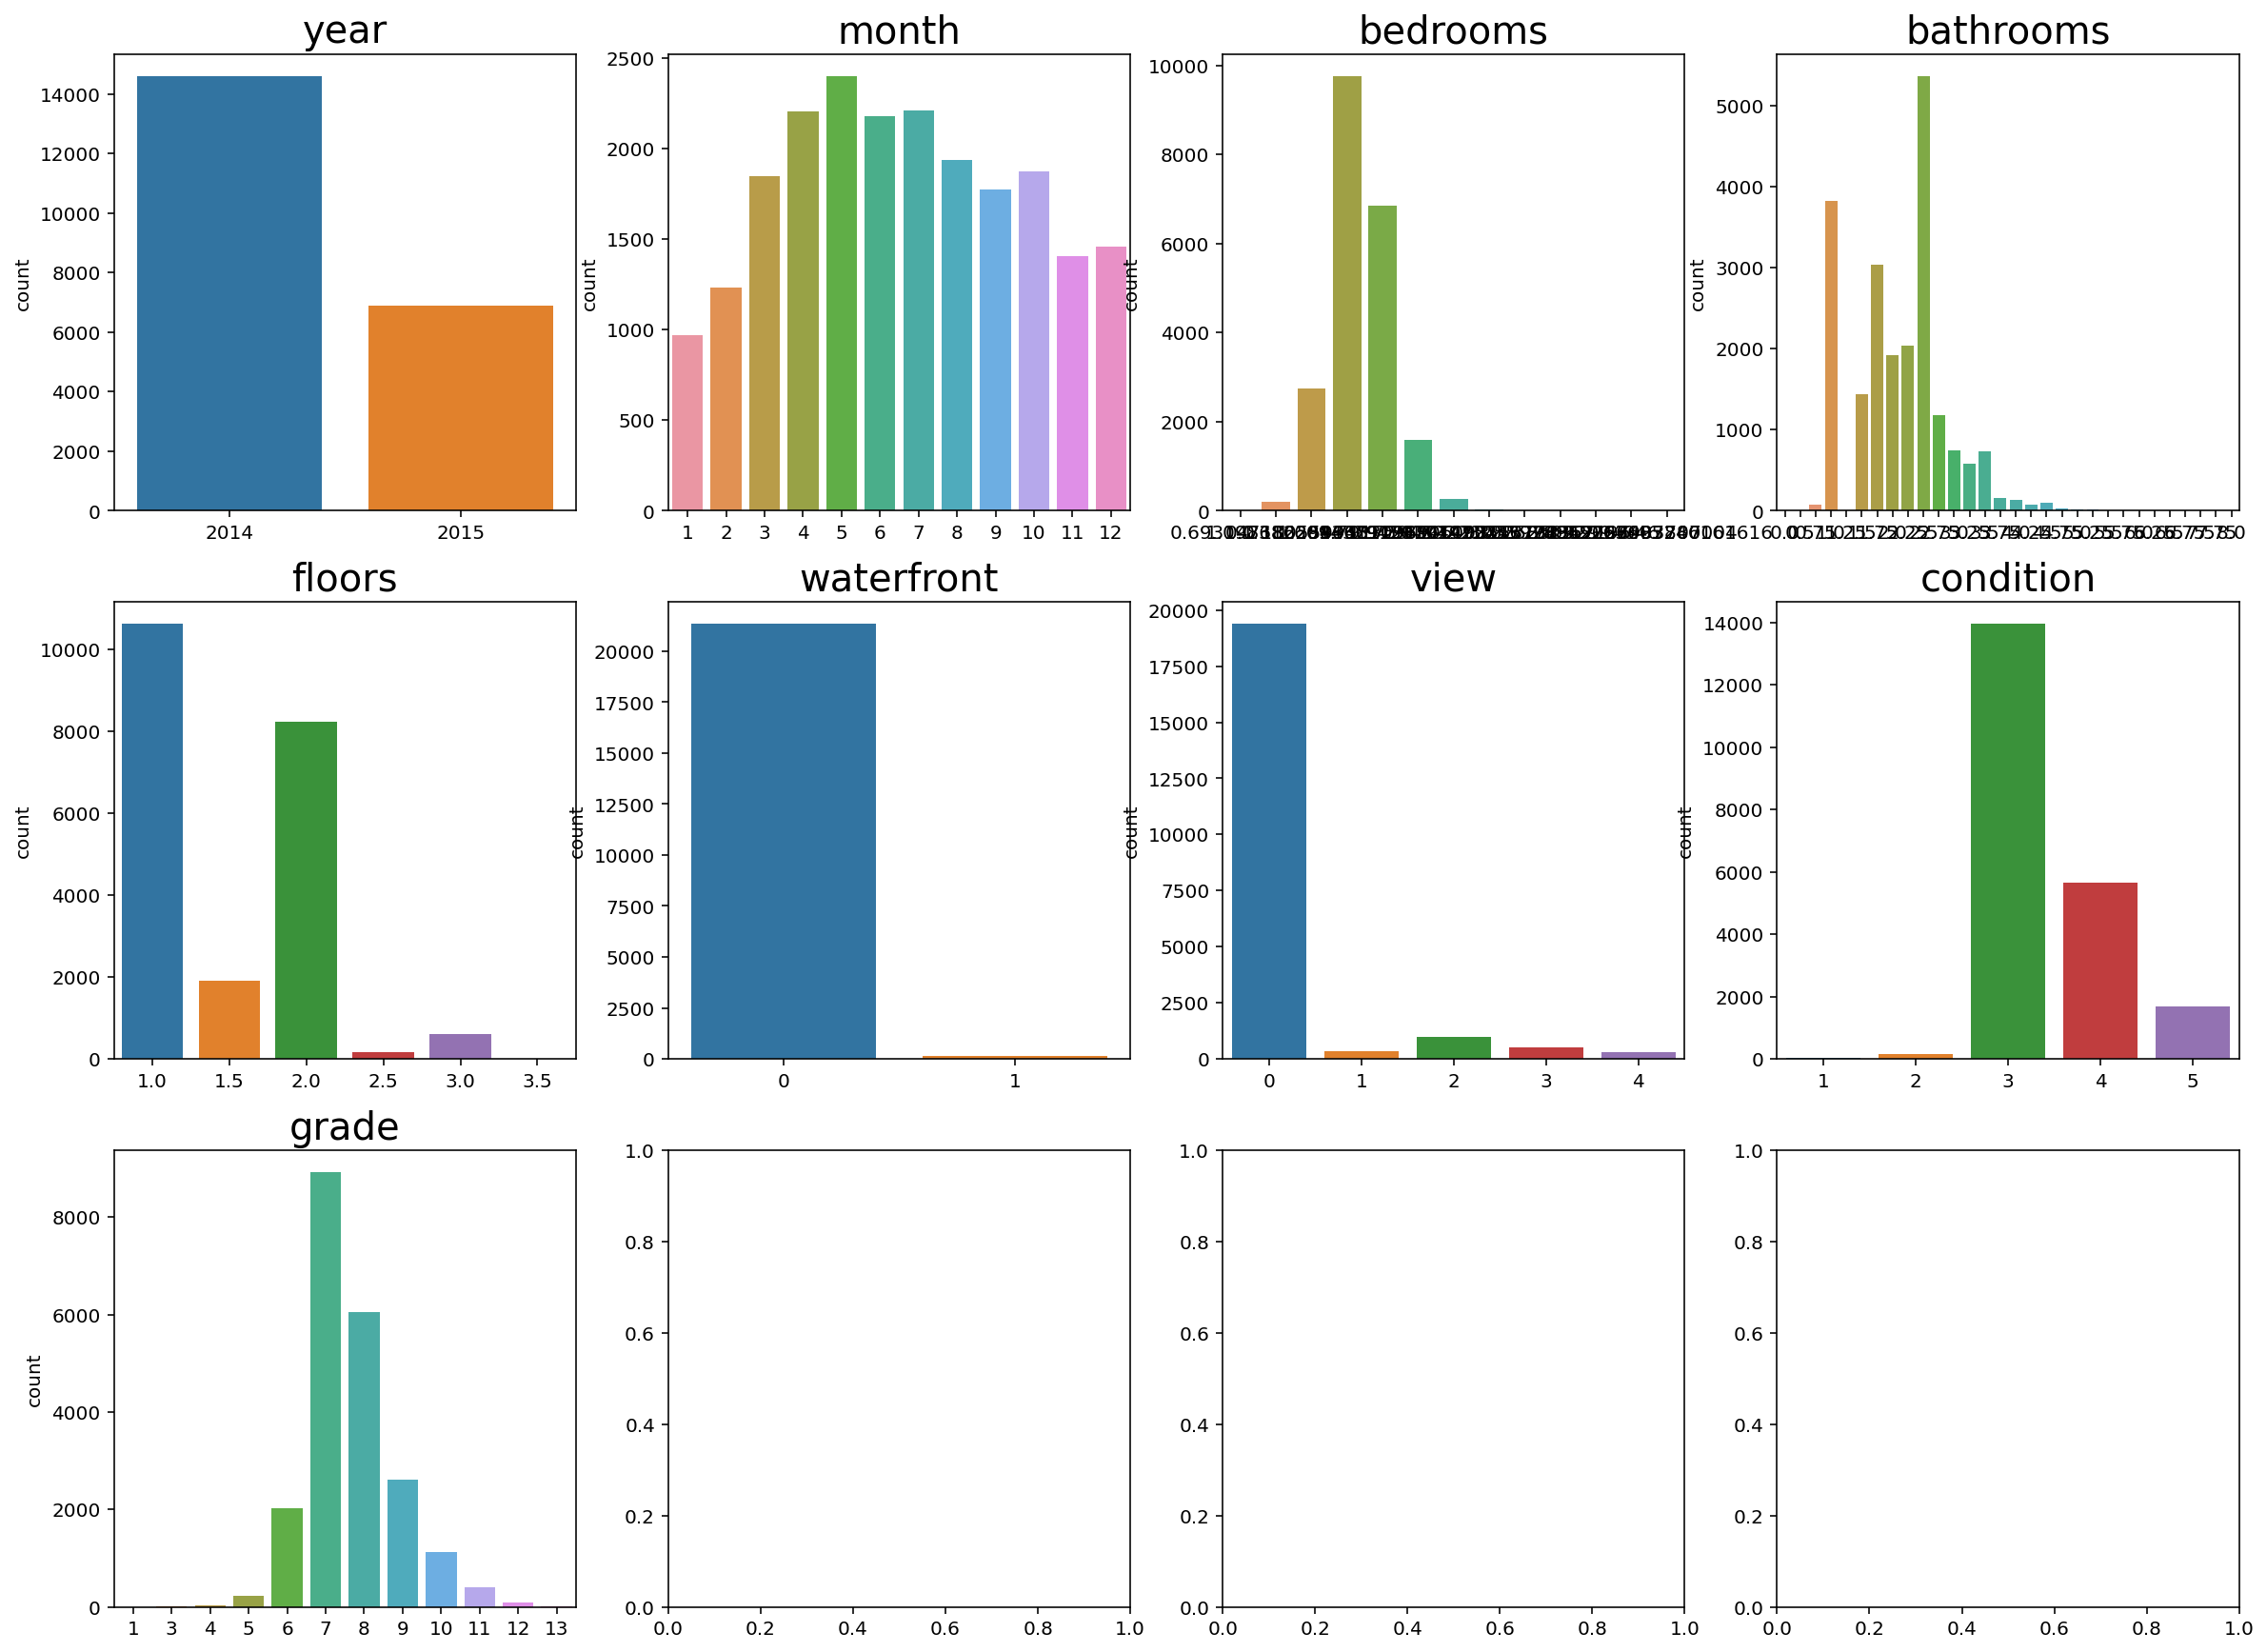

In [145]:
count_info = ['year', 'month', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for r in range(3):
    for c in range(4):
        index = 4 * r + c
        if index == len(count_info):
            break
        sns.countplot(data=data, x=count_info[index], ax=axes[r, c])
        axes[r, c].set_xlabel('')
        axes[r, c].set_title(count_info[index], fontsize=20)

### ▶ The price  only from 2014 to 2015.
### ▶ Grade, view, and condition were influnced on the price.
### ▶ Waterfront made large price difference.
### ▶  bathroom 
full bath : a toilet and sink, and either a bathtub with a shower, or a bathtub and a separate shower stall  
3/4 bath : containing toilet, sink, and shower  
half (1/2) bath (or powder room) : containing just a toilet and sink


full bath : 화장실, 세면대, 샤워실, 욕조  
3/4 bath : 화장실, 세면대, 샤워실  
half bath : 화장실, 세면대

In [146]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,201410,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,...,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588,2014,10
1,201502,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,...,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041,2015,2
2,201502,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,...,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191,2015,2
3,201406,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,...,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615,2014,6
4,201501,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,...,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118,2015,1


date column에서 뒤 2자를 추출하여 month를 고려해보고 싶은데....

In [157]:
data['year'] = train['date'].apply(lambda x:x[:4]).astype(int)
data['month'] = train['date'].apply(lambda x:x[4:6]).astype(int)
# data['day'] = data['date'].apply(lambda x:x[6:8]).astype(int) ---day는 없다.

ValueError: Could not interpret input 'month'

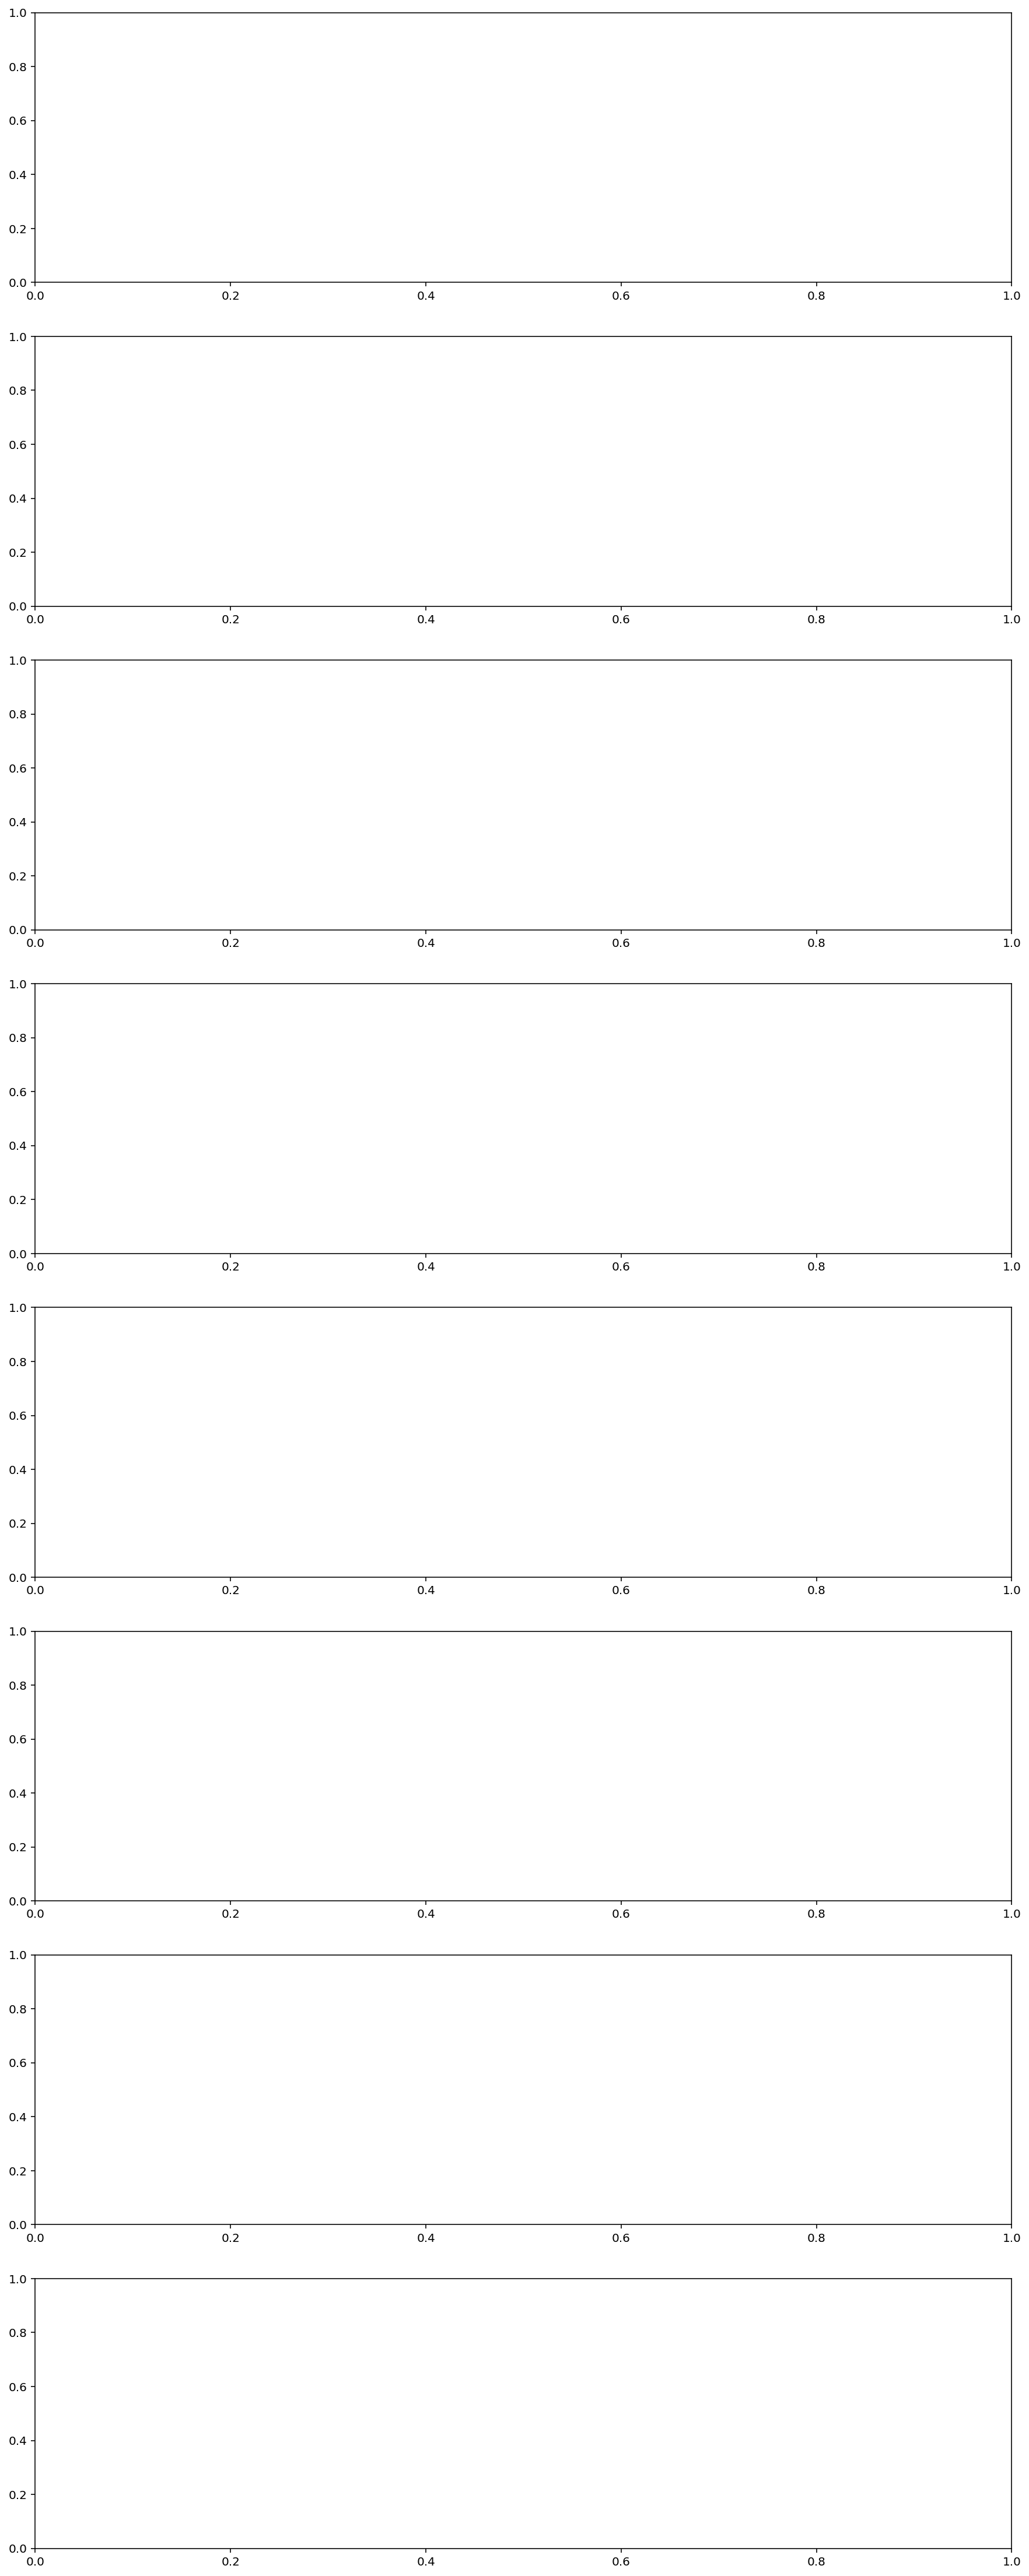

In [158]:
fig, axes = plt.subplots(nrows=8, figsize=(15, 40))

sns.pointplot(data=train, x='month', y='price', hue='year', ax=axes[1])
sns.pointplot(data=train, x='grade', y='price', hue='waterfront', ax=axes[2])
sns.pointplot(data=train, x='view', y='price', hue='waterfront', ax=axes[3])
sns.pointplot(data=train, x='condition', y='price', hue='waterfront', ax=axes[4])
sns.pointplot(data=train, x='floors', y='price', hue='waterfront', ax=axes[5])
sns.pointplot(data=train, x='bathrooms', y='price', hue='waterfront', ax=axes[6])
sns.pointplot(data=train, x='bedrooms', y='price', hue='waterfront', ax=axes[7])

title = ['Month', 'Grade', 'View', 'Condition', 'Floors', 'Bathrooms', 'Bedrooms']
for i in range(8):
    axes[i].set_xlabel('')
    axes[i].set_title(title[i], fontsize=15)
plt.show()

In [ ]:
date에서 추출하여 year와 month를 

ValueError: Could not interpret input 'year'

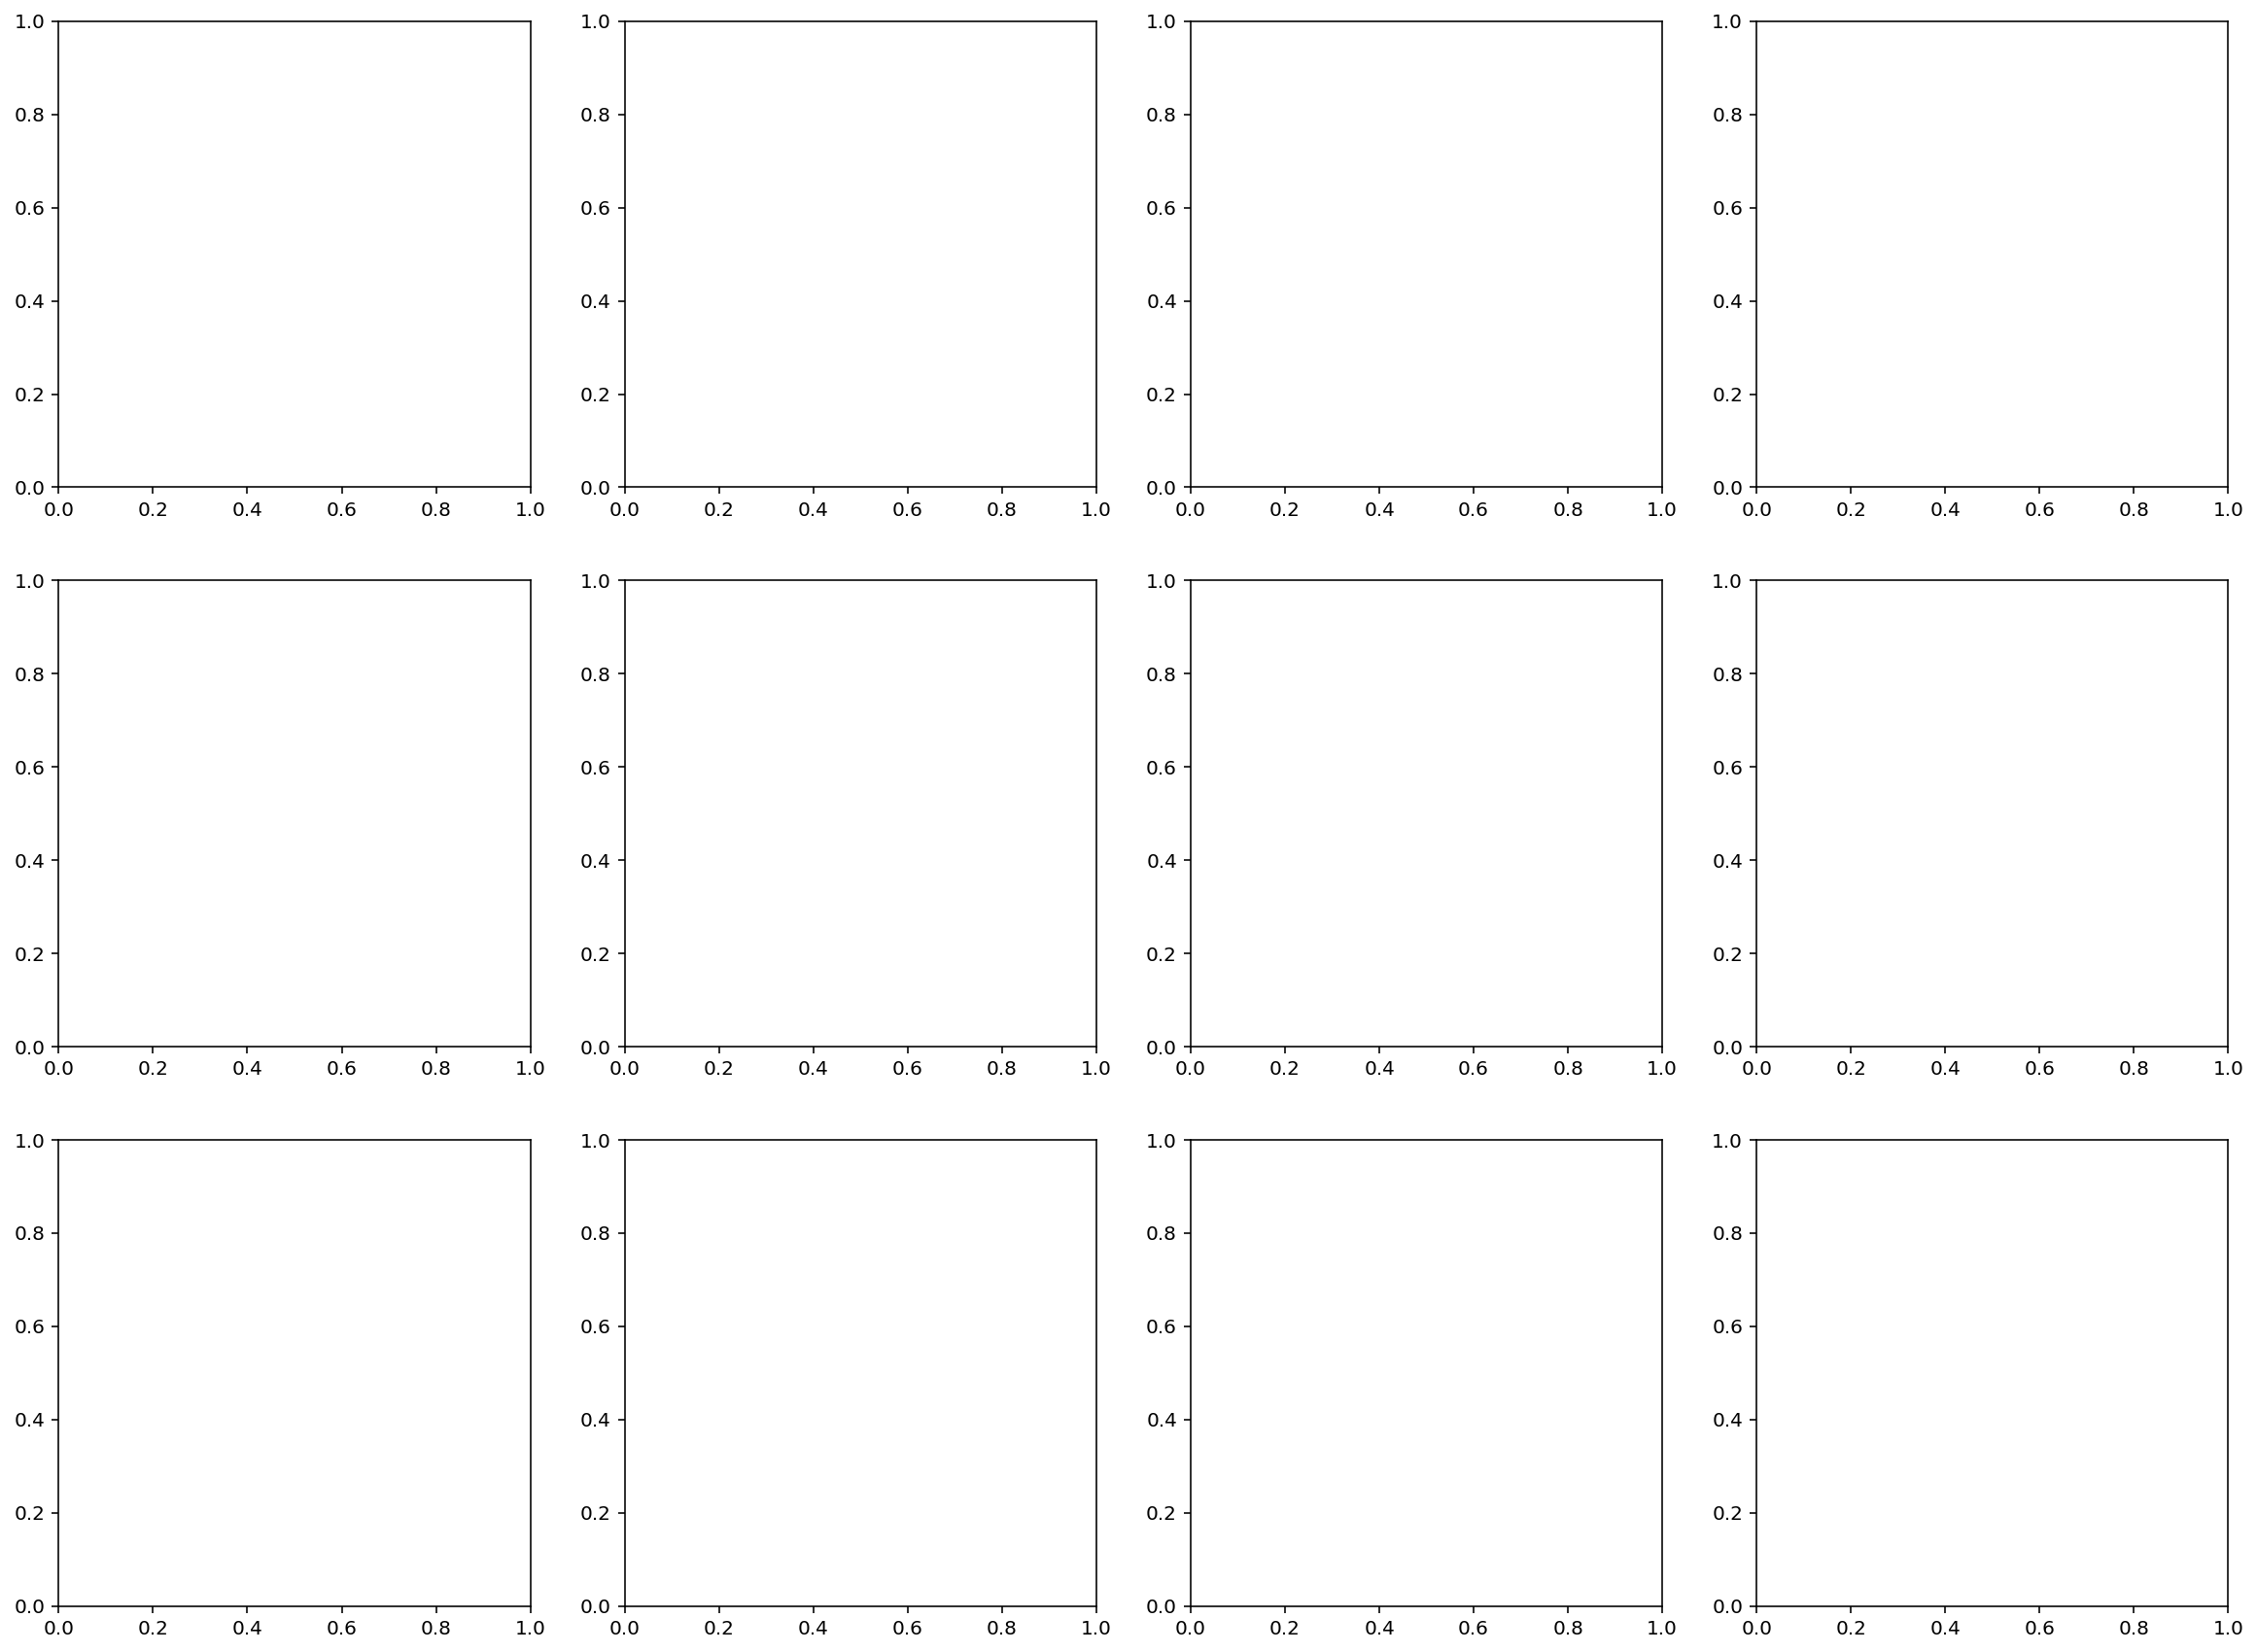

In [160]:
count_info = ['year', 'month', 'day', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for r in range(3):
    for c in range(4):
        index = 4 * r + c
        if index == len(count_info):
            break
        sns.countplot(data=train, x=count_info[index], ax=axes[r, c])
        axes[r, c].set_xlabel('')
        axes[r, c].set_title(count_info[index], fontsize=20)

#### ---> large standard deviation(std)   
Log scaling

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

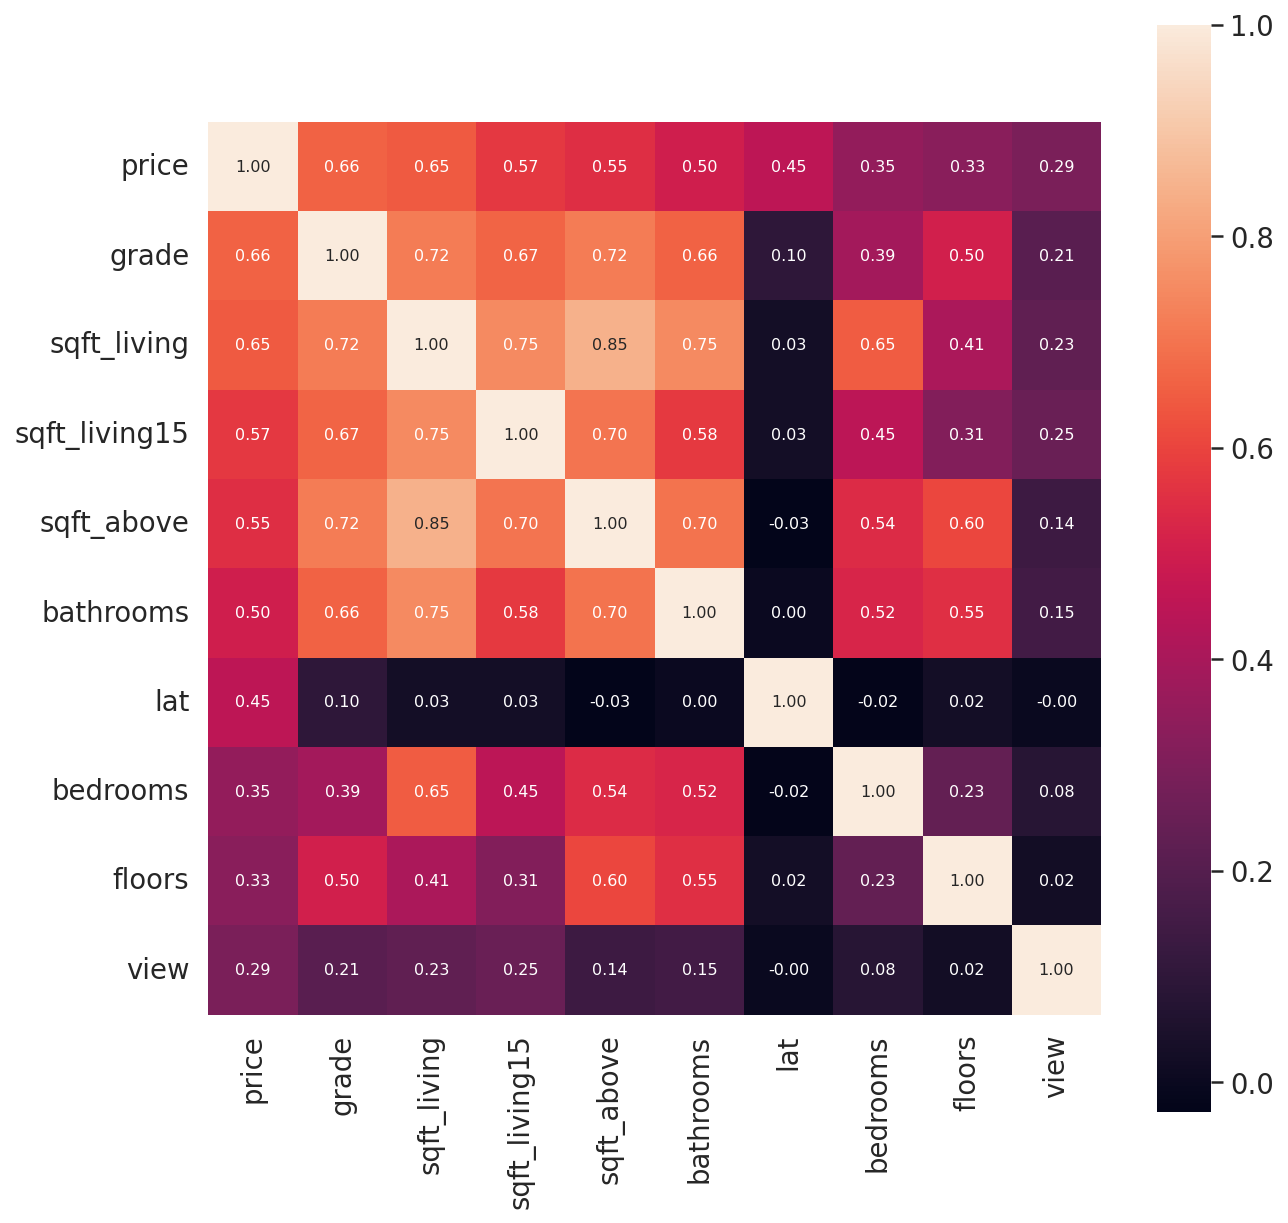

In [97]:
import scipy as sp

cor_abs = abs(data.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(data[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

# Reference : Kaggle ""

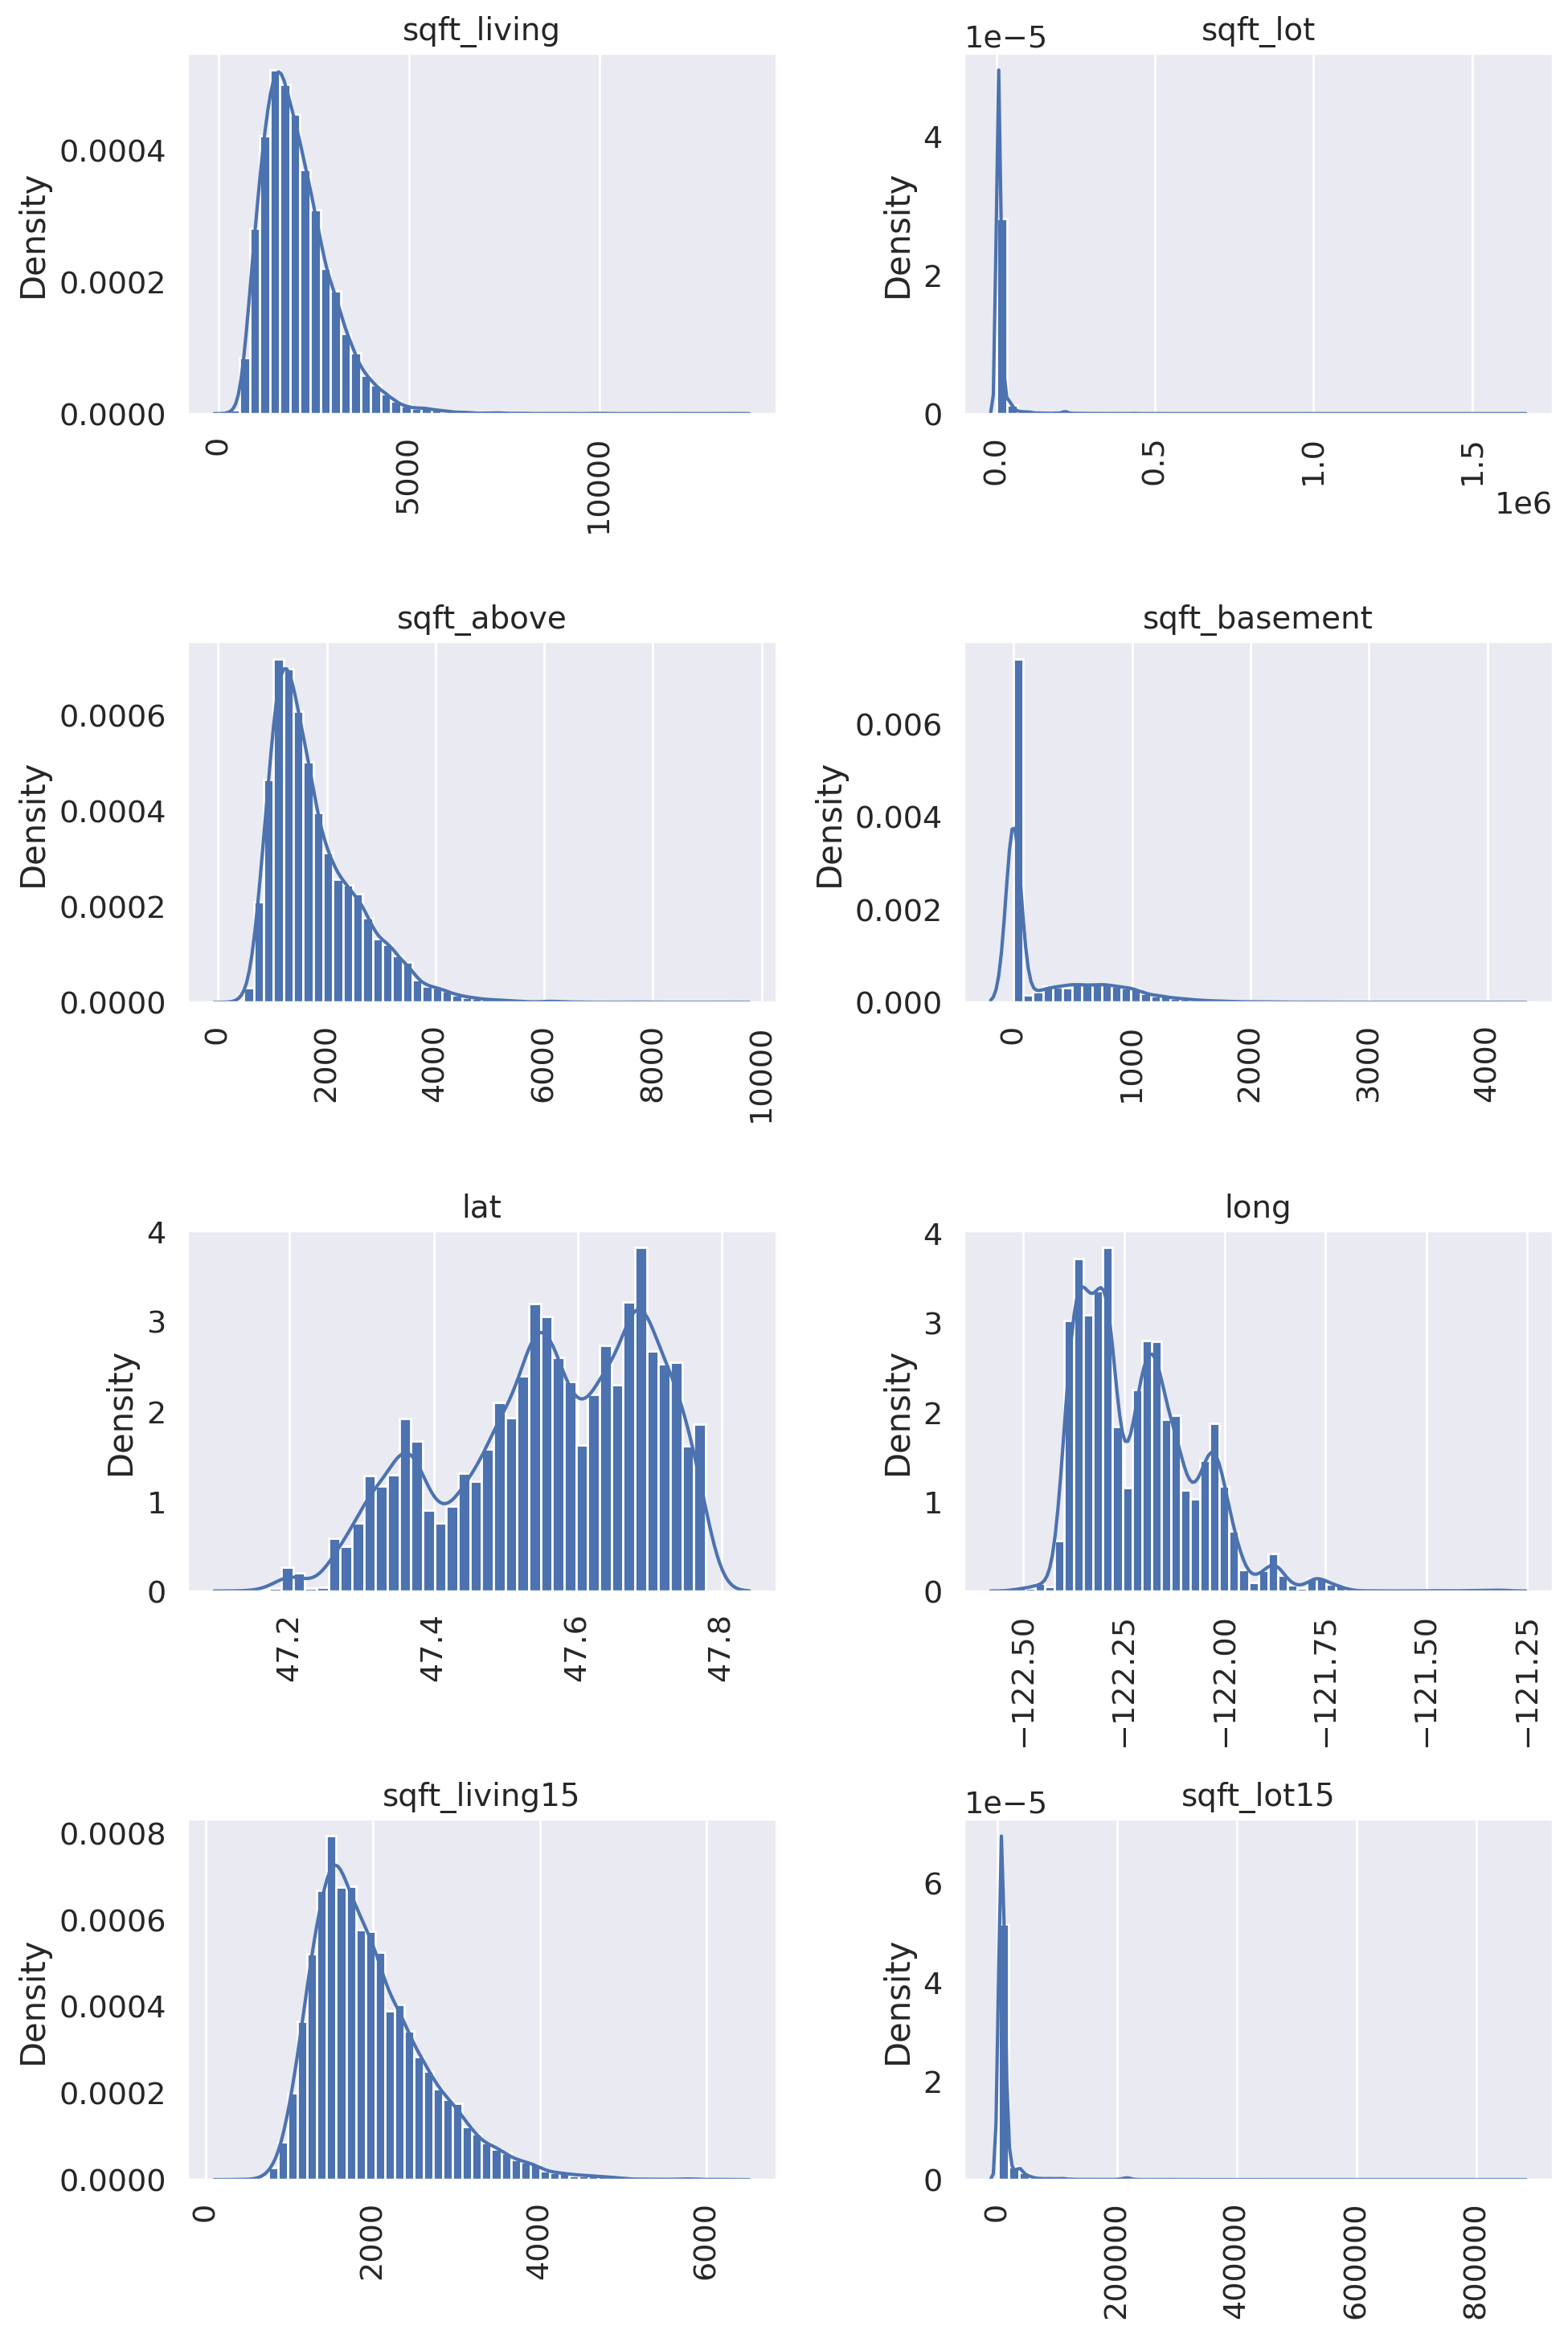

In [74]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15), dpi=100)

columns = [
    'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
    'lat', 'long', 'sqft_living15', 'sqft_lot15'
]

for i, col in enumerate(columns):
    sns.distplot(data[col].values, hist_kws={'alpha': 1}, ax=axes.flat[i])
    axes.flat[i].set_xlabel('')
    axes.flat[i].set_title(col, fontsize=14)
    axes.flat[i].grid(axis='y')
    axes.flat[i].tick_params(axis='x', rotation=90)
    
fig.suptitle('')
fig.tight_layout()
plt.show()

### Feature Engineering

# Learning

Root Mean Square Error (RMSE)  
The standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.

In [99]:
def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    error = np.expm1(predictions) - np.expm1(labels)
    squared_error = np.square(error)
    mean = np.mean(squared_error)
    return ('rmse_exp', np.sqrt(mean))

# Reference  


Kaggle: IVORYRABBIT



# Reviewing comments

잘 모르겠습니다.